In [21]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import math, statistics
import numpy as np
from scipy.spatial import distance

In [22]:
class CaseAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 10
        self.memory = []
        self.action = 0
        self.result=0
        self.cases = []
        self.deflator_cases = []
        self.circumstances = []
        self.action_set=[0.25, 0.5, 0.75]
        
    def get_circumstance(self):
        if len(model.realized_interest_rate_list) <=2:
            p_2 = random.choice(range(0,1))
            p_1 = 1                  
            new_circumstance = (p_2-p_1)/p_1
        else:
            new_circumstance =  (model.realized_interest_rate_list[-1]- model.realized_interest_rate_list[-2])/model.realized_interest_rate_list[-2]
        return new_circumstance
        print( "new circumstance is", new_circumstance, ".")
        
    def get_wealth(self):
        wealth = self.wealth
        return wealth
    
    def choose_action(self):
        if not self.cases:
            choice = random.choice(self.action_set)
            
        else:
            best_choice = self.evaluate_actions()    
            choice=random.choice(best_choice)
        return choice    
         
    
    def evaluate_actions(self):                  #evaluate all the actions and choose the one which has highest CBU
        cbu_list = list()
        for action in self.action_set:
            all_action_cbu = []
            new = np.array([action,self.get_circumstance()])
                
           
            for case in self.deflator_cases: #<--- looping through memory for each action, accumulate data in all_action_cbu    
                old =np.array([case["action"], case["circumstance"]])
                if abs(action-case["action"]) > model.B/2: #<--- do not consider this case, out of bandwidth
                    pass # you don't need to do anything here
                    
                else: #<--- consider this case and add to all_action_cbu
                    similarity =1/math.exp(distance.euclidean(new,old))
                    single_case_cbu = similarity*(case["result"] - model.H)
                    all_action_cbu.append(single_case_cbu)
             
            # Now, we have gone through all memory, and evaluate it for this action
            if len(all_action_cbu) == 0 : # I have found NO relevant cases in memory (TODO: CHECK CODE)
                cbu = 0
            else: # I have found at least one relevant case
                cbu = sum(all_action_cbu)

            act_value = {"action":action, "value":cbu}
            cbu_list.append(act_value)
            # now we have act_value for this action
   
        best_value = max(cbu_list, key=(lambda x: x["value"]))
        #print("best_value is ",best_value)
        best_choices= []
    
      

        for act_value in cbu_list:
            if act_value["value"] == best_value["value"]:
                best_choices.append(act_value["action"])
                
        return best_choices
        print(best_choices,".")            
    
    def get_flow_utility(self):
        consumption = self.wealth*self.action
        flow_utility = math.log(consumption)   #calculate each agent's payoff
        return flow_utility
        
    #def get_continuation_utility(self):
    
    def update_case(self):
        values = i.cases.values()
        values_list = list(values)
        i.cases[k]["result"]=i.cases
        return cases

In [126]:
class CaseModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, Bandwidth, H, beta,z,alpha,deflator,delta):
        self.num_agents = N
        # Create agents
        self.schedule = RandomActivation(self)
        self.actions=[]
        self.all_capital = []
        self.all_consumption = []
        self.total_K = 0
        self.consumption_list = []
        self.capital_list = []
        self.total_C = 0
        self.results=[]
        self.wealths=[]
        
        self.realized_interest_rate = 0
        self.realized_interest_rate_list = []
        self.real_wage = 0
        self.real_wage_list = []
        self.total_output=0
        self.output_list = []
        self.agents=[] #ADP: have an agents vector directly in Model.
        self.tick=0    #ADP: keep track of time.
        self.H = H
        self.B = Bandwidth
        self.beta = beta
        self.action_set=[0.25, 0.5, 0.75]
        self.z = z
        self.alpha = alpha
        self.deflator=None
        self.delta=delta
          # Create agents
        for i in range(self.num_agents):
            a = CaseAgent(i, self)
            self.schedule.add(a)
            self.agents.append(a)
        self.datacollector = DataCollector(
            model_reporters={"interest_rate": "realized_interest_rate",
                             "real_wage":"real_wage",
                            'GDP':"total_output",
                             "capital":"total_K",
                            "consumption":"total_C"},
            agent_reporters={"Wealth": "wealth", "Result": "result", "Action": "action", "Cases":"cases"})
        
    def reset(self):
        self.actions = []
        self.all_capital=[]
        self.all_consumption=[]
        self.results = []
        
    def calculate_price(self):
        total_K=sum(self.all_capital)
        realized_interest_rate =self.z*self.alpha*(total_K**(self.alpha-1))
        return realized_interest_rate
    
    def calculate_wage(self):
        total_K=sum(self.all_capital)
        real_wage =self.z*(1-self.alpha)*(total_K**self.alpha)
        return real_wage
    
    def get_output(self):
        total_K=sum(self.all_capital)
        total_output =self.z*(total_K**(self.alpha))
        return total_output
    
    def get_consumption(self):
        total_C=sum(self.all_consumption)
        return total_C
    
    def get_capital(self):
        total_K=sum(self.all_capital)
        return total_K
    
    def update_H(self):
        self.H = (self.H)*self.beta
        return self.H
    
    def initialize(self):
        
        for i in self.agents:
            i.action = random.choice(model.action_set)
            model.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            model.all_capital.append(i.current_capital)
        #print( "actions:", model.actions, ".") 
        #print( "all capital", model.all_capital, ".") 
        
    def step(self):
        '''Advance the model by one step.'''
        
        
        self.schedule.step()
        self.realized_interest_rate = self.calculate_price() 
        self.real_wage = self.calculate_wage()        
        model.realized_interest_rate_list.append(self.realized_interest_rate)
        model.real_wage_list.append(self.real_wage)
        self.total_output = self.get_output()  
        model.output_list.append(self.total_output)
        self.total_C = self.get_consumption() 
        self.total_K = self.get_capital()
        model.consumption_list.append(self.total_C)
        model.capital_list.append(self.total_K)
        print( "price:", self.realized_interest_rate, ".") #model calculate the market price  "circumstance"
        self.reset() 
        self.tick += 1 # ADP: iterate time.
        #previous_price = self.calculate_price()
        for i in self.agents:
            
            
            model.H = model.update_H()
            i.new_circumstance = i.get_circumstance()  #observe new circumstance
            #i.wealth = i.get_wealth()
            #print( "new circumstance:", i.new_circumstance, ".") 
            
            i.action = i.choose_action()
            #print( "choices:", i.evaluate_actions, ".") 
            #agents make predictions for each round "action"
           
            model.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            i.current_consumption = i.wealth*i.action
            
            model.all_capital.append(i.current_capital)
            model.all_consumption.append(i.current_consumption)
            
        
        #print("all past prices are:", model.realized_interest_rate_list)
        
        for i in self.agents: 
            i.result = i.get_flow_utility()                 #agents get their payoff for each round  "result"
            model.results.append(i.result)
            
            i.new_case = {"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.cases.append(i.new_case)
          
            i.deflator_case={"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.deflator_cases.append(i.deflator_case)
            for index in range(len(i.deflator_cases)):
                length=len(i.deflator_cases)
                i.deflator_cases[index]["result"]=i.deflator_cases[index]["result"]+model.delta**(length-index)*i.result
                
            #i.update_case()
            #print(i.cases[:3]) 
      
           
            #i.actions_chosen.append(i.prediction)
            i.wealth = i.current_capital*(1+model.realized_interest_rate)            #next period goods
        self.datacollector.collect(self)    
       
        
       
        print( "Time:", self.tick, ".") 
        #print( "Model_choices:", self.actions, ".")  
        #print( "Model_results:", self.results, ".")
      
       
         
    def print(self): 
        # ADP: Give every object a "print" function.
     
        print( "my__prediction", self.actions, ".")
        print( "realized_price", self.realized__interest_rate, ".")

price: 0.008109588425461198 .
Time: 1 .
price: 0.008696337801982132 .
Time: 2 .
price: 0.013323912830865401 .
Time: 3 .
price: 0.019027583133758658 .
Time: 4 .
price: 0.025405765937476923 .
Time: 5 .
price: 0.033002490265001586 .
Time: 6 .
price: 0.04248946237381908 .
Time: 7 .
price: 0.05375101021971053 .
Time: 8 .
price: 0.09797025078071855 .
Time: 9 .
price: 0.23469214390673426 .
Time: 10 .
price: 0.33691662093469277 .
Time: 11 .
price: 0.5340414959577282 .
Time: 12 .
price: 0.6540497200503917 .
Time: 13 .
price: 0.8829916651861945 .
Time: 14 .
price: 1.3882414375234282 .
Time: 15 .
price: 1.6124060251405925 .
Time: 16 .
price: 1.1242100763606513 .
Time: 17 .
price: 1.2452116776254554 .
Time: 18 .
price: 1.7980882712301907 .
Time: 19 .
price: 1.2727054624491116 .
Time: 20 .
price: 1.1334331660375128 .
Time: 21 .
price: 1.1137348403723264 .
Time: 22 .
price: 0.8652432546742128 .
Time: 23 .
price: 1.2469740050819305 .
Time: 24 .
price: 1.3862140008514412 .
Time: 25 .
price: 1.61335296

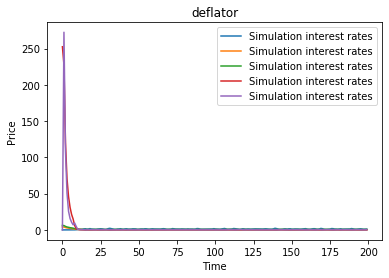

In [136]:
model = CaseModel(50,0.1,10,0.90,1,0.33,None,0.5)

model.initialize()
for i in range(200):
    model.step()    

    #model.print()
import matplotlib.pyplot as plt



# For jupyter notebook add the following line:
%matplotlib inline
all_data = model.datacollector.get_model_vars_dataframe()

plt.figure()

plt.plot(all_data,label="Simulation interest rates")


plt.xlabel("Time")
plt.ylabel("Price")
plt.title("deflator")
#
plt.legend()

#model.datacollector.get_agent_vars_dataframe()

#plt.figure()
plt.savefig('deflator.png')

In [148]:
import statistics as stat
import numpy as np
model.datacollector.get_agent_vars_dataframe()
data1 = model.datacollector.get_model_vars_dataframe()
data = data1[25:200]
gdp = data["GDP"]
consumption = data["consumption"]
wage = data["real_wage"]
capital = data["capital"]
i = data["interest_rate"]
data

#plt.plot(model.datacollector.get_agent_vars_dataframe())

,interest_rate,real_wage,GDP,capital,consumption
25,1.613353,0.306627,0.457652,0.093610,0.170191
26,1.456495,0.322470,0.481298,0.109048,0.114324
27,1.119948,0.367023,0.547795,0.161412,0.123570
28,0.766252,0.442462,0.660391,0.284409,0.112097
29,1.111089,0.368461,0.549942,0.163336,0.439597
30,1.820068,0.288950,0.431268,0.078194,0.210299
31,2.205835,0.262847,0.392308,0.058691,0.106384
32,1.767747,0.293131,0.437509,0.081673,0.083838
33,1.189703,0.356261,0.531733,0.147492,0.114339
34,0.834720,0.424198,0.633132,0.250304,0.157918


In [150]:
r_cy = np.corrcoef(gdp,consumption)
r_cy

array([[1.        , 0.17885221],
       [0.17885221, 1.        ]])

In [151]:
r_wy = np.corrcoef(gdp,wage)
r_wy

array([[1., 1.],
       [1., 1.]])

In [152]:
r_Ky = np.corrcoef(gdp,capital)
r_Ky

array([[1.        , 0.98946185],
       [0.98946185, 1.        ]])

In [153]:

r_iy = np.corrcoef(gdp,i)
r_iy

array([[ 1.        , -0.97656817],
       [-0.97656817,  1.        ]])

In [154]:
y_std = np.std(gdp)
y_std

0.053311691575634756

In [155]:
c_std = np.std(consumption)
c_std

0.069898550786602

In [156]:
K_std = np.std(capital)
K_std

0.04410086690750185